In [2]:
import pymongo
import datetime 
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import statsmodels.api as sm
import scipy as sp
from sklearn.preprocessing import StandardScaler
import re

In [3]:
class Database(object):
    def __init__(self):
        self.connection = pymongo.MongoClient(mongo_server, 27017)
        self.db = self.connection["project"]
        self.mov = self.db["movie"]
        self.act = self.db["actor"]
        self.dir = self.db['director']
        self.fra = self.db['franchise']
        
def get_score(name, idt, year):
    idt = idt.split('/')
    idt = datetime.date(int(idt[2])+2000, int(idt[0]), int(idt[1]))
    ytd = datetime.timedelta(days = 365*year)

    score = 0
    for mov in name :
        if len(name[mov]) == 4 :
            if name[mov][2] != 'NA':
                mdt = name[mov][2].split('/')
                mdt = datetime.date(int(mdt[2])+2000, int(mdt[0]), int(mdt[1]))
                if idt - mdt < ytd and datetime.timedelta(0) < idt - mdt:
                    if name[mov][3] != 'NA' :
                        score += name[mov][3]

    return score

def get_score_avg(name, idt, year):
    idt = idt.split('/')
    idt = datetime.date(int(idt[2])+2000, int(idt[0]), int(idt[1]))
    ytd = datetime.timedelta(days = 365*year)
    count = 0.
    score = 0.
    for mov in name :
        if len(name[mov]) == 4 :
            if name[mov][2] != 'NA':
                mdt = name[mov][2].split('/')
                mdt = datetime.date(int(mdt[2])+2000, int(mdt[0]), int(mdt[1]))
                if idt - mdt < ytd and datetime.timedelta(0) < idt - mdt:
                    if name[mov][3] != 'NA' :
                        count += 1.
                        score += name[mov][3]
    return score / count


db = Database()

In [4]:
movies = db.mov.find({'gross_us' : {'$exists' : 'True'}, 'project_budget' : {'$ne' : 'NA'}})
movies.count()

627

# 데이터 전처리

In [5]:
dict_act = {}
actors = db.act.find()
for act in actors:
    dict_act[act['name']] = act['movie']
dict_dir = {}
directors = db.dir.find()
for dire in directors:
    dict_dir[dire['name']] = dire['movie']
dict_fra = {}
franchise = db.fra.find()
for fra in franchise:
    dict_fra[fra['name']] = fra['movie']

In [6]:
arr_col = ['Mname','director','franchise','release_kor','grade',
           'project_budget','actor','grade','release_kor','viewing_time',
           'year','genre','nation', 'gross_us', 'gross_kor']
movies = db.mov.find({'gross_us' : {'$exists' : 'True'}})
data = [] 
pass_list = ['Genres','People','Franchises','Showdowns','Indices','(Voice)','(Cameo)', '(Narrator)','RZA','\n',' ']
for n, line in enumerate(movies):
    movie = defaultdict(lambda: list())
    for key in arr_col :
        if (line[key] == 'NA') or (line[key] == -1):
            line[key] = np.nan
        movie[key] = line[key]
    if isinstance(movie['nation'], list) and u'한국' in movie['nation'] :
        pass
    else :
        score_act = 0
        score_dir = 0
        score_fra = 0
        for it in movie['actor']:  
            if it in dict_act.keys():
                if it not in pass_list:
                    try:
                        it = re.sub('\*','',it)
                        score_act += get_score(dict_act[it], movie['release_kor'], 5)
                    except:
                        pass
                    
        for it in movie['director']:
            if it in dict_dir.keys():
                 if it != 'People':
                    score_dir += get_score(dict_dir[it], movie['release_kor'], 10)
        for it in movie['franchise']:
            score_fra += get_score(dict_fra[it], movie['release_kor'], 10)
        movie['score_act'] = score_act
        movie['score_dir'] = score_dir
        movie['score_fra'] = score_fra
        data.append(movie)
df = pd.DataFrame(data)

In [8]:
df.score_act = df.score_act.replace(0,np.nan)
df.score_dir = df.score_dir.replace(0,np.nan)

In [10]:
dfn = df.dropna().reset_index(drop = 1)

In [11]:
dfn

,Mname,actor,director,franchise,genre,grade,gross_kor,gross_us,nation,project_budget,release_kor,score_act,score_dir,score_fra,viewing_time,year
0,Transformers: Age of Extinction,"{u'TJ Miller': u'NA', u'Kelsey Grammer': u'/pe...",{u'Michael Bay': u'/people/chart/?view=Directo...,{u'Series: Transformers': u'/franchises/chart/...,[SF],12세이상관람가,43338590.0,245439076.0,[미국],210000000.0,6/26/14,35540077.0,185584928.0,163971758,164.0,2014
1,The Hobbit: The Battle of the Five Armies,"{u' ': u'NA', u'Lee Pace': u'NA', u'Evangeline...",{u'Peter Jackson': u'/people/chart/?view=Direc...,{u'Series: Middle Earth': u'/franchises/chart/...,[판타지],12세이상관람가,22351681.0,255119788.0,"[뉴질랜드, 미국]",250000000.0,12/17/14,461625930.0,64227230.0,76160998,144.0,2014
2,The Hunger Games: Mockingjay - Part 1,"{u'Donald Sutherland': u'NA', u'Philip Seymour...",{u'Francis Lawrence': u'/people/chart/?view=Di...,{u'Series: The Hunger Games': u'/franchises/ch...,"[액션, 어드벤처]",15세이상관람가,5804110.0,337135885.0,[미국],125000000.0,11/20/14,278846895.0,36683095.0,11299160,123.0,2014
3,X-Men: Days of Future Past,{u'Omar Sy': u'/people/chart/?view=Actor&id=om...,{u'Bryan Singer': u'/people/chart/?view=Direct...,{u'Series: X-Men': u'/franchises/chart/?id=xme...,"[액션, 어드벤처, 판타지]",12세이상관람가,33716901.0,233921534.0,[미국],200000000.0,5/22/14,383899915.0,26559242.0,44034238,134.0,2014
4,Dawn of the Planet of the Apes,{u'Gary Oldman': u'/people/chart/?view=Actor&i...,{u'Matt Reeves': u'/people/chart/?view=Directo...,{u'Series: Planet of the Apes': u'/franchises/...,"[SF, 액션, 드라마, 스릴러]",12세이상관람가,30594006.0,208545589.0,[미국],170000000.0,7/10/14,178579885.0,4858681.0,17321073,130.0,2014
5,The Amazing Spider-Man 2,{u'Andrew Garfield': u'/people/chart/?view=Act...,{u'Marc Webb': u'/people/chart/?view=Director&...,{u'Series: Spider-Man': u'/franchises/chart/?i...,"[액션, 어드벤처, 판타지]",12세이상관람가,33797633.0,202853933.0,[미국],200000000.0,4/24/14,160959401.0,38059780.0,83020952,142.0,2014
6,Interstellar,{u'Matthew McConaughey': u'/people/chart/?view...,{u'Christopher Nolan': u'/people/chart/?view=D...,{},[SF],12세이상관람가,68974677.0,188020017.0,[미국],165000000.0,11/6/14,339511808.0,115475196.0,0,169.0,2014
7,Big Hero 6,"{u' ': u'NA', u'Genesis Rodriguez ': u'NA', u'...",{u'Chris Williams': u'/people/chart/?view=Dire...,{},"[애니메이션, 액션, 코미디]",전체관람가,20136819.0,222527828.0,[미국],165000000.0,1/21/15,164826467.0,3600363.0,0,108.0,2014
8,How to Train Your Dragon 2,"{u' ': u'NA', u'Christopher Mintz-Plasse': u'N...",{u'Dean DeBlois': u'/people/chart/?view=Direct...,{u'Series: How to Train Your Dragon': u'/franc...,"[애니메이션, 액션, 어드벤처]",전체관람가,22610977.0,177002924.0,[미국],145000000.0,7/23/14,268936201.0,25108317.0,25108317,101.0,2014
9,American Sniper,"{u'Sienna Miller': u'NA', u'Bradley Cooper': u...",{u'Clint Eastwood': u'/people/chart/?view=Dire...,{},"[액션, 드라마]",청소년관람불가,1922403.0,350126372.0,[미국],58800000.0,1/14/15,18986538.0,10651406.0,0,132.0,2014


# 더미변수 생성

In [12]:
season_dum = pd.DataFrame(np.zeros((len(dfn), 5)),columns = ['sp_d','su_d','au_d','wi_d','season'])
for i, mon in enumerate(dfn.release_kor):
    mon = int(mon.split('/')[0])
    if 3 <= mon < 6 :
        season_dum.ix[i, 0] = 1
        season_dum.ix[i, 4] = 0
    elif 6 <= mon < 9 :
        season_dum.ix[i, 1] = 1
        season_dum.ix[i, 4] = 1
    elif 9 <= mon < 12 :
        season_dum.ix[i, 2] = 1
        season_dum.ix[i, 4] = 2
    else :
        season_dum.ix[i, 3] = 1
        season_dum.ix[i, 4] = 3
dfn = dfn.join(season_dum)

In [13]:
#장르 더미
genre = [u'\uac00\uc871',
 u'\uc2dc\ub300\uadf9',
 u'\uc2a4\ub9b4\ub7ec',
 u'\ub4dc\ub77c\ub9c8',
 u'\uc560\ub2c8\uba54\uc774\uc158',
 u'\uc804\uc7c1',
 u'\uc5b4\ub4dc\ubca4\ucc98',
 u'\uacf5\ud3ec',
 u'\ud310\ud0c0\uc9c0',
 u'\ubbf8\uc2a4\ud130\ub9ac',
 u'\ub2e4\ud050\uba58\ud130\ub9ac',
 u'\uc11c\ubd80',
 u'\ub85c\ub9e8\uc2a4/\uba5c\ub85c',
 u'\uc561\uc158',
 u'\ubc94\uc8c4',
 u'\ucf54\ubbf8\ub514',
 u'\ubb34\ud611',
 u'SF',
 u'\ubba4\uc9c0\uceec']
dummies = pd.DataFrame(np.zeros((len(dfn), len(genre))), columns=genre)
for i, gen in enumerate(dfn.genre):
    for j in gen:
        dummies.ix[i, j] = 1./len(gen)
gen = np.arange(len(genre))
dummies.columns = gen
dfn = dfn.join(dummies.add_prefix('Genre_'))

In [14]:
#등급 더미
dfgrade = pd.get_dummies(dfn.grade)
del dfgrade[u'']
dfgrade.columns = [12,15,0,18]
dfn = dfn.join(dfgrade)

In [15]:
dfn

,Mname,actor,director,franchise,genre,grade,gross_kor,gross_us,nation,project_budget,...,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,12,15,0,18
0,Transformers: Age of Extinction,"{u'TJ Miller': u'NA', u'Kelsey Grammer': u'/pe...",{u'Michael Bay': u'/people/chart/?view=Directo...,{u'Series: Transformers': u'/franchises/chart/...,[SF],12세이상관람가,43338590.0,245439076.0,[미국],210000000.0,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,1,0,0,0
1,The Hobbit: The Battle of the Five Armies,"{u' ': u'NA', u'Lee Pace': u'NA', u'Evangeline...",{u'Peter Jackson': u'/people/chart/?view=Direc...,{u'Series: Middle Earth': u'/franchises/chart/...,[판타지],12세이상관람가,22351681.0,255119788.0,"[뉴질랜드, 미국]",250000000.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0,0,0
2,The Hunger Games: Mockingjay - Part 1,"{u'Donald Sutherland': u'NA', u'Philip Seymour...",{u'Francis Lawrence': u'/people/chart/?view=Di...,{u'Series: The Hunger Games': u'/franchises/ch...,"[액션, 어드벤처]",15세이상관람가,5804110.0,337135885.0,[미국],125000000.0,...,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0,1,0,0
3,X-Men: Days of Future Past,{u'Omar Sy': u'/people/chart/?view=Actor&id=om...,{u'Bryan Singer': u'/people/chart/?view=Direct...,{u'Series: X-Men': u'/franchises/chart/?id=xme...,"[액션, 어드벤처, 판타지]",12세이상관람가,33716901.0,233921534.0,[미국],200000000.0,...,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,1,0,0,0
4,Dawn of the Planet of the Apes,{u'Gary Oldman': u'/people/chart/?view=Actor&i...,{u'Matt Reeves': u'/people/chart/?view=Directo...,{u'Series: Planet of the Apes': u'/franchises/...,"[SF, 액션, 드라마, 스릴러]",12세이상관람가,30594006.0,208545589.0,[미국],170000000.0,...,0.250000,0.000000,0.000000,0.0,0.250000,0.000000,1,0,0,0
5,The Amazing Spider-Man 2,{u'Andrew Garfield': u'/people/chart/?view=Act...,{u'Marc Webb': u'/people/chart/?view=Director&...,{u'Series: Spider-Man': u'/franchises/chart/?i...,"[액션, 어드벤처, 판타지]",12세이상관람가,33797633.0,202853933.0,[미국],200000000.0,...,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,1,0,0,0
6,Interstellar,{u'Matthew McConaughey': u'/people/chart/?view...,{u'Christopher Nolan': u'/people/chart/?view=D...,{},[SF],12세이상관람가,68974677.0,188020017.0,[미국],165000000.0,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,1,0,0,0
7,Big Hero 6,"{u' ': u'NA', u'Genesis Rodriguez ': u'NA', u'...",{u'Chris Williams': u'/people/chart/?view=Dire...,{},"[애니메이션, 액션, 코미디]",전체관람가,20136819.0,222527828.0,[미국],165000000.0,...,0.333333,0.000000,0.333333,0.0,0.000000,0.000000,0,0,1,0
8,How to Train Your Dragon 2,"{u' ': u'NA', u'Christopher Mintz-Plasse': u'N...",{u'Dean DeBlois': u'/people/chart/?view=Direct...,{u'Series: How to Train Your Dragon': u'/franc...,"[애니메이션, 액션, 어드벤처]",전체관람가,22610977.0,177002924.0,[미국],145000000.0,...,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0,0,1,0
9,American Sniper,"{u'Sienna Miller': u'NA', u'Bradley Cooper': u...",{u'Clint Eastwood': u'/people/chart/?view=Dire...,{},"[액션, 드라마]",청소년관람불가,1922403.0,350126372.0,[미국],58800000.0,...,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0,1


In [16]:
import sys
for n, i in enumerate(genre):
    sys.stdout.write('%d%s ' %(n,i))

0가족 1시대극 2스릴러 3드라마 4애니메이션 5전쟁 6어드벤처 7공포 8판타지 9미스터리 10다큐멘터리 11서부 12로맨스/멜로 13액션 14범죄 15코미디 16무협 17SF 18뮤지컬 

# imputation 시도

In [53]:
df2 = dfn.copy()

In [54]:
df2.score_act = df2.score_act.replace(0,np.nan)
df2.score_dir = df2.score_dir.replace(0,np.nan)

In [55]:
df2['score_dir'] = df2['score_dir'].fillna(df2['score_dir'].min())
df2['score_act'] = df2['score_act'].fillna(df2['score_act'].min())

In [56]:
tmp = pd.DataFrame(df2, columns =['Mname','score_dir', 'score_act', 'gross_kor','project_budget'])
tmp= tmp.sort_values(by=['score_act'], ascending =[False] )
tmp

,Mname,score_dir,score_act,gross_kor,project_budget
46,Avengers: Age of Ultron,50683851.0,1.723147e+09,78286828.0,250000000.0
297,Captain America: Civil War,60355202.0,1.693858e+09,62859896.0,250000000.0
199,The Dark Knight Rises,75327896.0,8.616217e+08,41992822.0,250000000.0
55,Ant-Man,8326964.0,8.382102e+08,20784172.0,130000000.0
305,X-Men: Apocalypse,60276143.0,6.627553e+08,20642326.0,178000000.0
313,Now You See Me 2,25944909.0,6.386744e+08,21711248.0,90000000.0
299,The Jungle Book (2016),54049571.0,5.406618e+08,18901624.0,175000000.0
333,"Hail, Caesar!",3551730.0,5.198341e+08,232969.0,22000000.0
1,The Hobbit: The Battle of the Five Armies,64227230.0,4.616259e+08,22351681.0,250000000.0
311,Star Trek Beyond,26605554.0,4.430240e+08,9126493.0,185000000.0


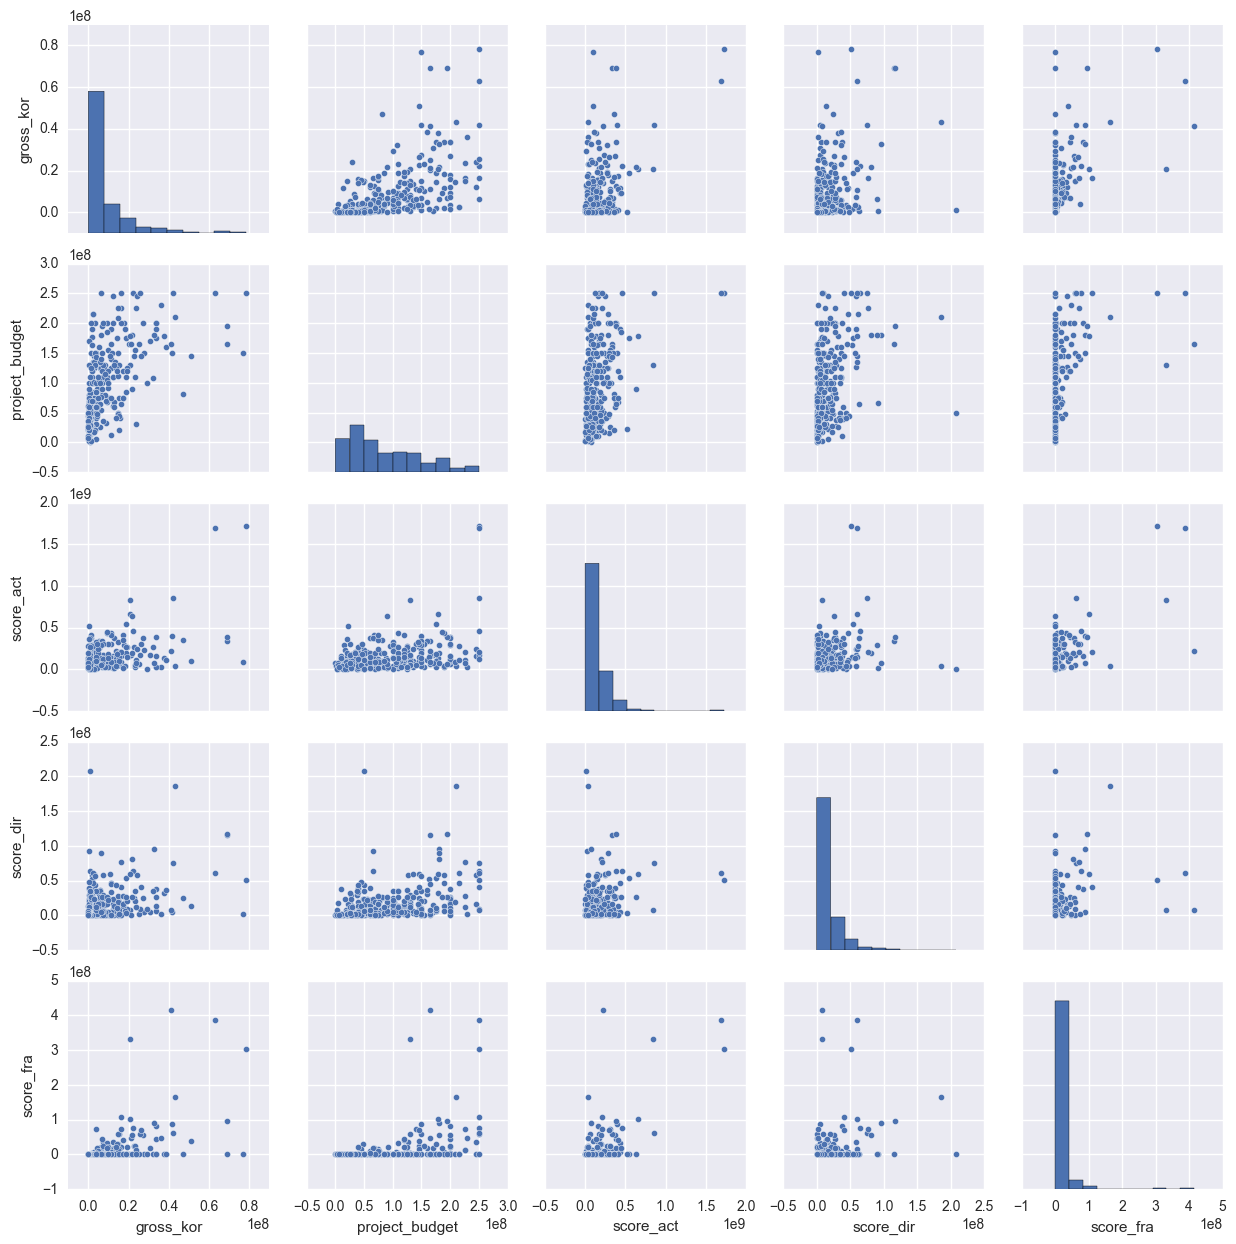

In [48]:
sns.pairplot(df2, vars=['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra'])
plt.show()

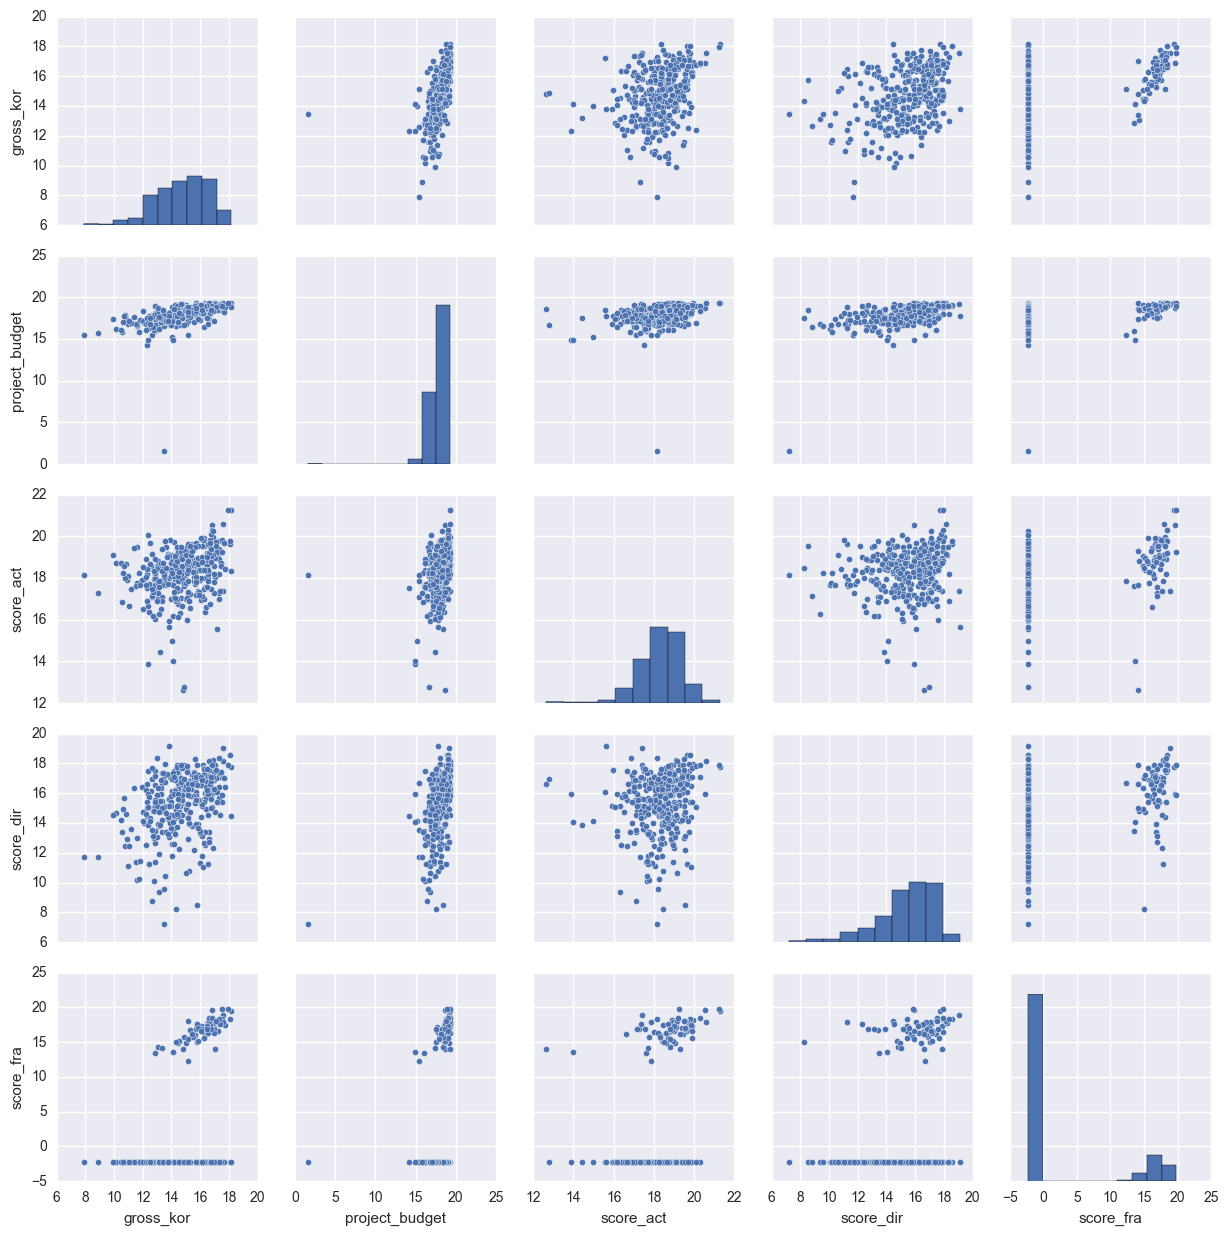

In [160]:
new_dfn = df2.ix[:,['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra']]
new_dfn['score_fra'] = np.log(new_dfn['score_fra'] + 0.1)
new_dfn['gross_kor'] = np.log(new_dfn['gross_kor'])
new_dfn['score_act'] = np.log(new_dfn['score_act'])
new_dfn['score_dir'] = np.log(new_dfn['score_dir'])
new_dfn['project_budget'] = np.log(new_dfn['project_budget'])
sns.pairplot(new_dfn)
plt.show()

In [51]:
imp_dfx = pd.DataFrame(df2, columns= [ u'project_budget', u'score_act', u'score_dir', u'score_fra',
    u'Genre_0', u'Genre_1', u'Genre_2', u'Genre_3', u'Genre_4', u'Genre_5', u'Genre_6',
    u'Genre_7', u'Genre_8', u'Genre_9', u'Genre_10', u'Genre_11', u'Genre_12',
    u'Genre_13', u'Genre_14', u'Genre_15', u'Genre_16', u'Genre_17', u'Genre_18',
                                    'sp_d','su_d','au_d','wi_d',0,12,15,18])
imp_dfy = pd.DataFrame(dfn, columns = ['gross_kor'])

In [60]:
imputation_model = sm.OLS(imp_dfy, imp_dfx)
imp_result = imputation_model.fit()
print(imp_result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     12.79
Date:                Wed, 15 Mar 2017   Prob (F-statistic):           2.36e-36
Time:                        15:34:21   Log-Likelihood:                -5941.2
No. Observations:                 342   AIC:                         1.194e+04
Df Residuals:                     314   BIC:                         1.205e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
project_budget     0.0808      0.012      6.

In [61]:
dfn

,Mname,actor,director,franchise,genre,grade,gross_kor,gross_us,nation,project_budget,...,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,12,15,0,18
0,Transformers: Age of Extinction,"{u'TJ Miller': u'NA', u'Kelsey Grammer': u'/pe...",{u'Michael Bay': u'/people/chart/?view=Directo...,{u'Series: Transformers': u'/franchises/chart/...,[SF],12세이상관람가,43338590.0,245439076.0,[미국],210000000.0,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,1,0,0,0
1,The Hobbit: The Battle of the Five Armies,"{u' ': u'NA', u'Lee Pace': u'NA', u'Evangeline...",{u'Peter Jackson': u'/people/chart/?view=Direc...,{u'Series: Middle Earth': u'/franchises/chart/...,[판타지],12세이상관람가,22351681.0,255119788.0,"[뉴질랜드, 미국]",250000000.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0,0,0
2,The Hunger Games: Mockingjay - Part 1,"{u'Donald Sutherland': u'NA', u'Philip Seymour...",{u'Francis Lawrence': u'/people/chart/?view=Di...,{u'Series: The Hunger Games': u'/franchises/ch...,"[액션, 어드벤처]",15세이상관람가,5804110.0,337135885.0,[미국],125000000.0,...,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0,1,0,0
3,X-Men: Days of Future Past,{u'Omar Sy': u'/people/chart/?view=Actor&id=om...,{u'Bryan Singer': u'/people/chart/?view=Direct...,{u'Series: X-Men': u'/franchises/chart/?id=xme...,"[액션, 어드벤처, 판타지]",12세이상관람가,33716901.0,233921534.0,[미국],200000000.0,...,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,1,0,0,0
4,Dawn of the Planet of the Apes,{u'Gary Oldman': u'/people/chart/?view=Actor&i...,{u'Matt Reeves': u'/people/chart/?view=Directo...,{u'Series: Planet of the Apes': u'/franchises/...,"[SF, 액션, 드라마, 스릴러]",12세이상관람가,30594006.0,208545589.0,[미국],170000000.0,...,0.250000,0.000000,0.000000,0.0,0.250000,0.000000,1,0,0,0
5,The Amazing Spider-Man 2,{u'Andrew Garfield': u'/people/chart/?view=Act...,{u'Marc Webb': u'/people/chart/?view=Director&...,{u'Series: Spider-Man': u'/franchises/chart/?i...,"[액션, 어드벤처, 판타지]",12세이상관람가,33797633.0,202853933.0,[미국],200000000.0,...,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,1,0,0,0
6,Interstellar,{u'Matthew McConaughey': u'/people/chart/?view...,{u'Christopher Nolan': u'/people/chart/?view=D...,{},[SF],12세이상관람가,68974677.0,188020017.0,[미국],165000000.0,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,1,0,0,0
7,Big Hero 6,"{u' ': u'NA', u'Genesis Rodriguez ': u'NA', u'...",{u'Chris Williams': u'/people/chart/?view=Dire...,{},"[애니메이션, 액션, 코미디]",전체관람가,20136819.0,222527828.0,[미국],165000000.0,...,0.333333,0.000000,0.333333,0.0,0.000000,0.000000,0,0,1,0
8,How to Train Your Dragon 2,"{u' ': u'NA', u'Christopher Mintz-Plasse': u'N...",{u'Dean DeBlois': u'/people/chart/?view=Direct...,{u'Series: How to Train Your Dragon': u'/franc...,"[애니메이션, 액션, 어드벤처]",전체관람가,22610977.0,177002924.0,[미국],145000000.0,...,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0,0,1,0
9,American Sniper,"{u'Sienna Miller': u'NA', u'Bradley Cooper': u...",{u'Clint Eastwood': u'/people/chart/?view=Dire...,{},"[액션, 드라마]",청소년관람불가,1922403.0,350126372.0,[미국],58800000.0,...,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0,1


In [17]:
dfn.ix[:,21:-5].tail()

,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17
337,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
338,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0
340,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
341,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print(dfn.describe())

          gross_kor      gross_us  project_budget     score_act     score_dir  \
count  3.420000e+02  3.420000e+02    3.420000e+02  3.420000e+02  3.420000e+02   
mean   8.043754e+06  1.092535e+08    8.673655e+07  1.449476e+08  1.572088e+07   
std    1.230259e+07  1.056951e+08    6.325488e+07  1.746747e+08  2.369641e+07   
min    2.695000e+03  1.632650e+05    5.000000e+00  3.061350e+05  1.358000e+03   
25%    7.001442e+05  3.751938e+07    3.500000e+07  4.732174e+07  1.761148e+06   
50%    2.906370e+06  7.899852e+07    7.000000e+07  9.763794e+07  7.510500e+06   
75%    1.101211e+07  1.435970e+08    1.300000e+08  1.830429e+08  2.082607e+07   
max    7.828683e+07  9.366622e+08    2.500000e+08  1.723147e+09  2.073103e+08   

          score_fra  viewing_time         year        sp_d        su_d  \
count  3.420000e+02    342.000000   342.000000  342.000000  342.000000   
mean   1.081453e+07    115.991228  2012.915205    0.274854    0.245614   
std    4.304297e+07     18.988573     1.994524  

In [19]:
df_n0 = dfn[dfn['score_dir']!=0].reset_index(drop = 1)
df_n0 = df_n0[df_n0['score_act']!=0].reset_index(drop = 1)

In [20]:
dfx = pd.DataFrame(df_n0, columns= [ u'project_budget', u'score_act', u'score_dir', u'score_fra',
    u'Genre_0', u'Genre_1', u'Genre_2', u'Genre_3', u'Genre_4', u'Genre_5', u'Genre_6',
    u'Genre_7', u'Genre_8', u'Genre_9', u'Genre_10', u'Genre_11', u'Genre_12',
    u'Genre_13', u'Genre_14', u'Genre_15', u'Genre_16', u'Genre_17', u'Genre_18',
                                    'sp_d','su_d','au_d','wi_d',0,12,15,18])
dfy = pd.DataFrame(df_n0, columns = ['gross_kor'])

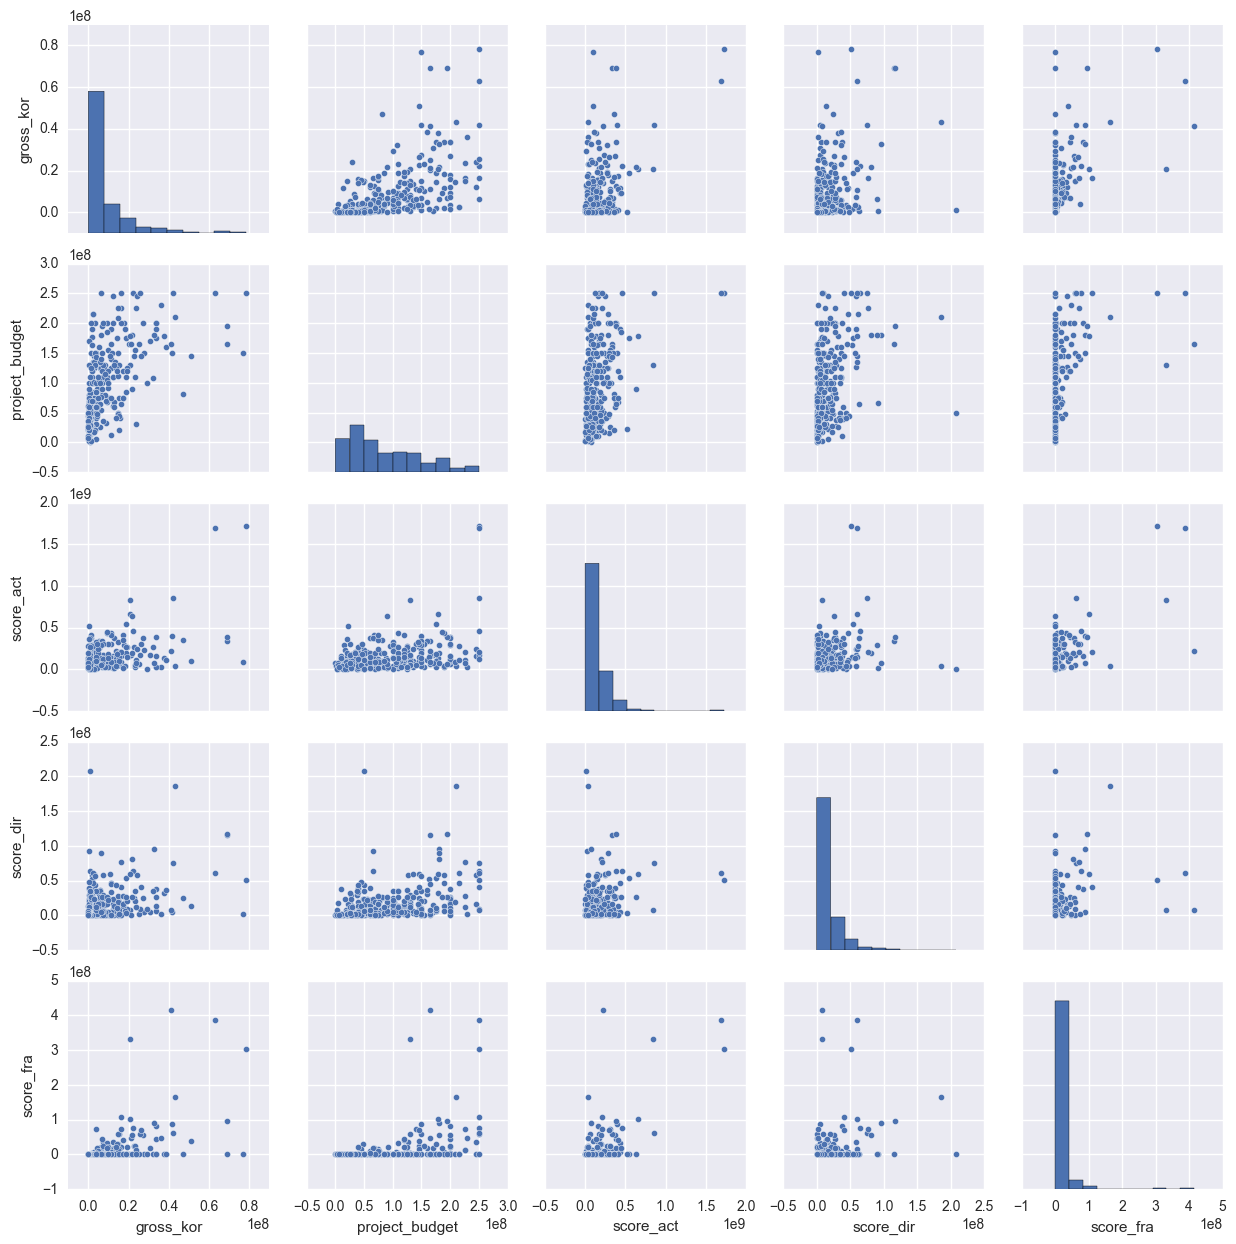

In [21]:
sns.pairplot(df_n0, vars=['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra'])
plt.show()

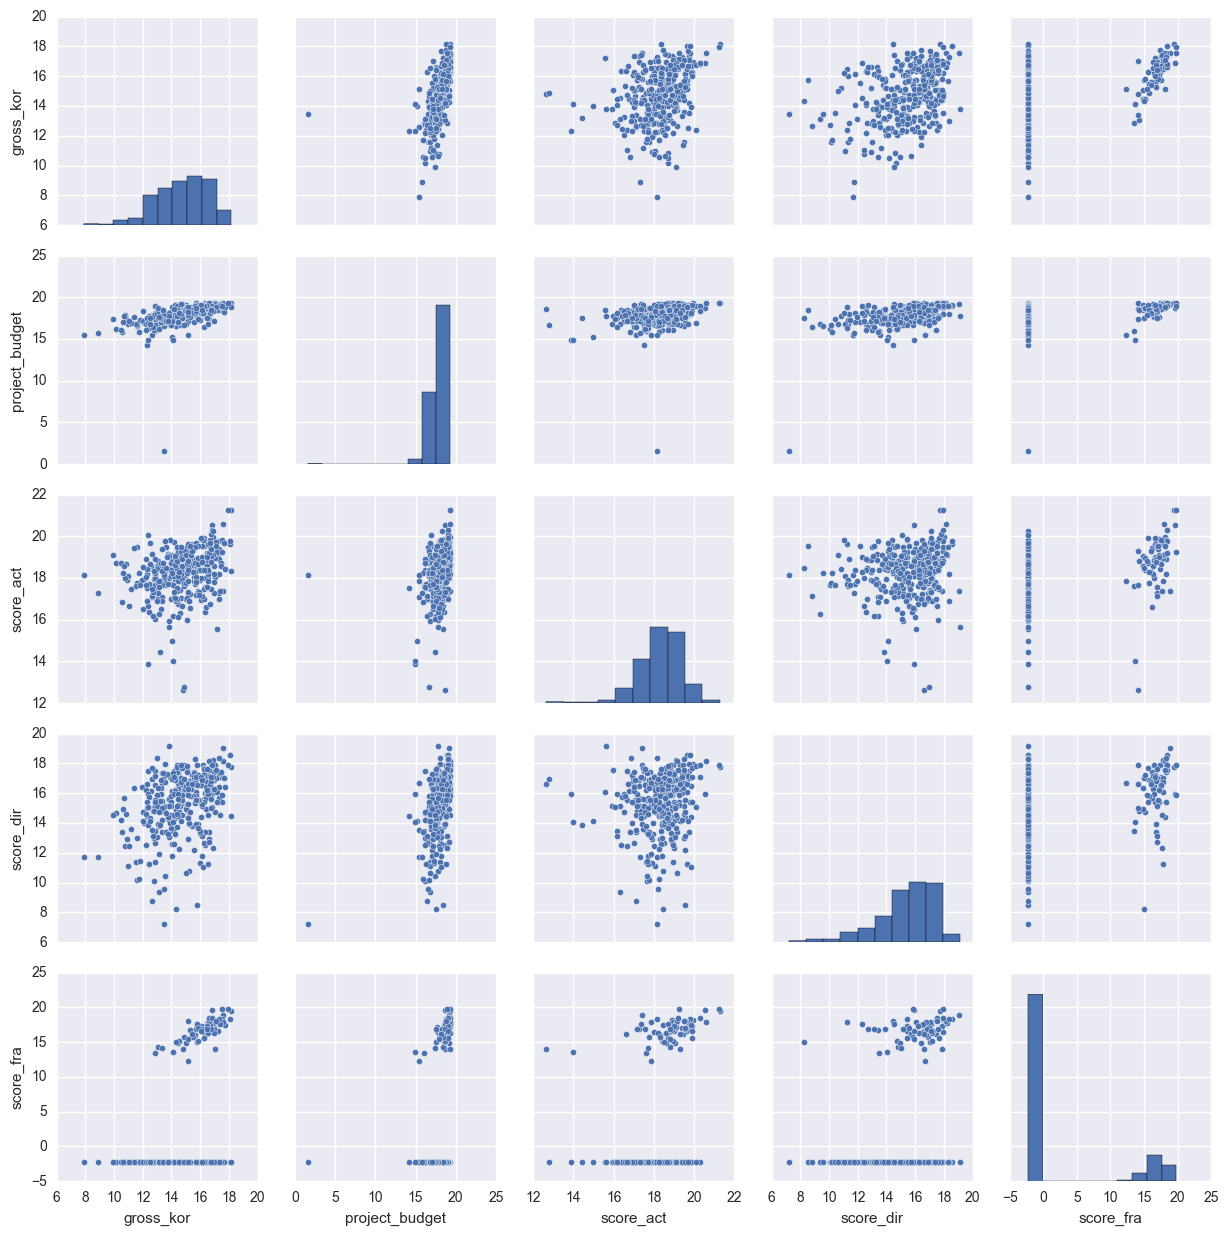

In [22]:
new_dfn = df_n0.ix[:,['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra']]
new_dfn['score_fra'] = np.log(new_dfn['score_fra'] + 0.1)
new_dfn['gross_kor'] = np.log(new_dfn['gross_kor'])
new_dfn['score_act'] = np.log(new_dfn['score_act'])
new_dfn['score_dir'] = np.log(new_dfn['score_dir'])
new_dfn['project_budget'] = np.log(new_dfn['project_budget'])
sns.pairplot(new_dfn)
plt.show()

In [ ]:
dfx = sm.add_constant(dfx, has_constant='add')
len(dfx.columns)

# 1. OLS 모형 만들기

In [24]:
model = sm.OLS( dfy['gross_kor'], dfx)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     12.79
Date:                Fri, 17 Mar 2017   Prob (F-statistic):           2.36e-36
Time:                        09:35:25   Log-Likelihood:                -5941.2
No. Observations:                 342   AIC:                         1.194e+04
Df Residuals:                     314   BIC:                         1.205e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const          -6.763e+06   4.47e+06     -1.

In [25]:
#로그변환
#dfx['log_bud'] = np.log(dfx['project_budget'])
dfx['score_act'] = np.log(dfx['score_act'])
dfx['score_dir'] = np.log(dfx['score_dir'])
dfx['score_fra'] = np.log(dfx['score_fra'] + 0.1)
dfx['project_budget'] = np.log(dfx['project_budget'])
dfy = np.log(dfy)
#del dfx['project_budget']
#del dfx['score_act']
#del dfx['score_dir']
#sns.pairplot(dfx.join(dfy), vars=['project_budget', 'score_act', 'score_dir','gross_kor'])
#plt.show()

# 2. 로그 변환

In [26]:
model = sm.OLS(dfy, dfx)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     10.54
Date:                Fri, 17 Mar 2017   Prob (F-statistic):           2.76e-30
Time:                        09:35:25   Log-Likelihood:                -576.14
No. Observations:                 342   AIC:                             1208.
Df Residuals:                     314   BIC:                             1316.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              4.3235      1.524      2.

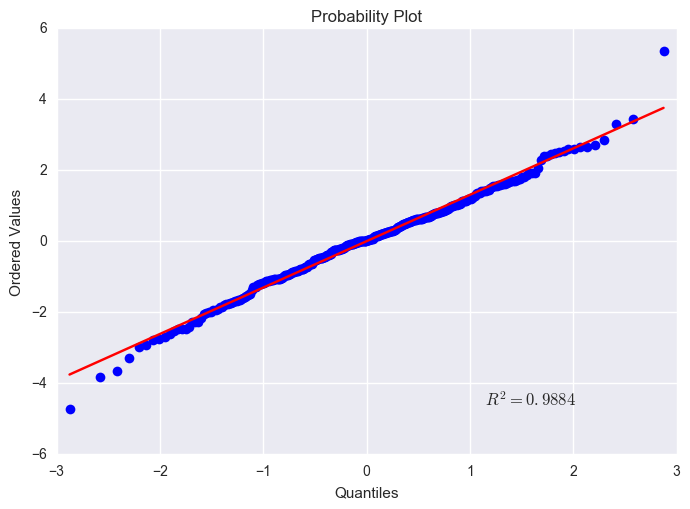

In [27]:
#아웃라이어
plt.figure()
sp.stats.probplot(result.resid, plot = plt)
plt.show()

In [28]:
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 /float(len(dfx)-2)
idx = np.where(cooks_d2 < fox_cr)[0]
dfx2 = dfx.ix[idx,:].reset_index(drop = 1)
dfy2 = dfy.ix[idx,:].reset_index(drop = 1)

# 3. 아웃라이어 제거

In [29]:
model2 = sm.OLS(dfy2['gross_kor'], dfx2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     16.61
Date:                Fri, 17 Mar 2017   Prob (F-statistic):           1.70e-43
Time:                        09:35:27   Log-Likelihood:                -470.34
No. Observations:                 320   AIC:                             994.7
Df Residuals:                     293   BIC:                             1096.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             -2.6632      1.664     -1.

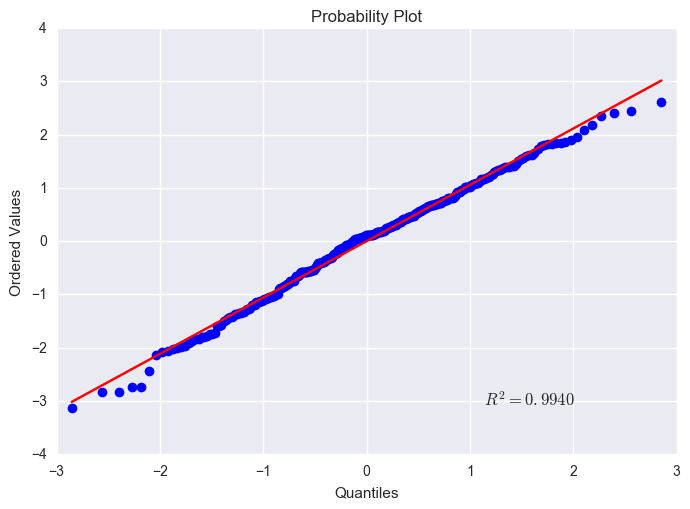

In [30]:
plt.figure()
sp.stats.probplot(result2.resid, plot = plt)
plt.show()

In [31]:
dfx3 = dfx2.copy()

In [32]:
dfy3 = dfy2.copy()

In [35]:
dfx3.columns

Index([         u'const', u'project_budget',      u'score_act',
            u'score_dir',      u'score_fra',        u'Genre_0',
              u'Genre_1',        u'Genre_2',        u'Genre_3',
              u'Genre_4',        u'Genre_5',        u'Genre_6',
              u'Genre_7',        u'Genre_8',        u'Genre_9',
             u'Genre_10',       u'Genre_11',       u'Genre_12',
             u'Genre_13',       u'Genre_14',       u'Genre_15',
             u'Genre_16',       u'Genre_17',       u'Genre_18',
                 u'sp_d',           u'su_d',           u'au_d',
                 u'wi_d',                 0,                12,
                      15,                18],
      dtype='object')

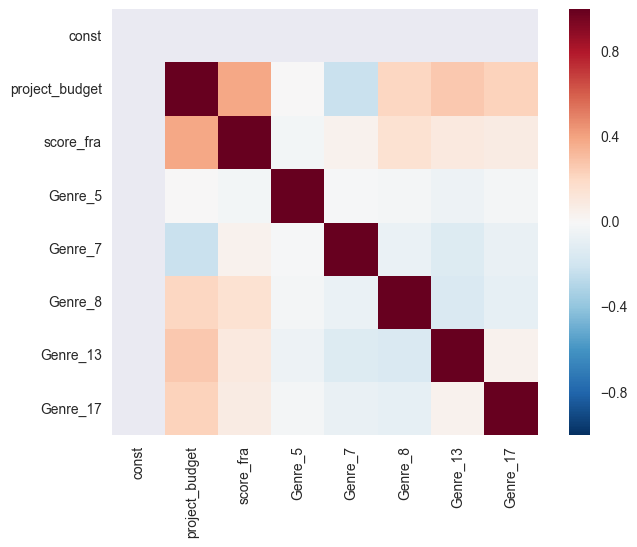

In [88]:
corrmat = dfx5.corr()
sns.heatmap(corrmat, square= True)
plt.show()

In [39]:
dfx4

,project_budget,score_act,score_dir,score_fra,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,...,Genre_17,Genre_18,sp_d,su_d,au_d,wi_d,0,12,15,18
0,1.303261,-0.777251,1.808904,2.094144,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,1.000000,0.000000,0.0,1.0,0.0,0.0,0,1,0,0
1,1.496450,1.454668,1.272046,1.998891,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1.0,0,1,0,0
2,0.728422,1.015881,0.988656,1.761874,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,1.0,0.0,0,0,1,0
3,1.249200,1.294180,0.825265,1.930836,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,1.0,0.0,0.0,0.0,0,1,0,0
4,1.069124,0.627984,-0.034151,1.814938,0.000000,0.0,0.250000,0.250000,0.000000,0.0,...,0.250000,0.000000,0.0,1.0,0.0,0.0,0,1,0,0
5,1.249200,0.537558,1.007296,2.009604,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,1.0,0.0,0.0,0.0,0,1,0,0
6,1.036047,1.187225,1.568852,-0.541419,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,1.000000,0.000000,0.0,0.0,1.0,0.0,0,1,0,0
7,1.036047,0.558224,-0.185801,-0.541419,0.000000,0.0,0.000000,0.000000,0.333333,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1.0,1,0,0,0
8,0.892876,0.984380,0.796841,1.861056,0.000000,0.0,0.000000,0.000000,0.333333,0.0,...,0.000000,0.000000,0.0,1.0,0.0,0.0,1,0,0,0
9,-0.107222,-1.322963,0.362983,-0.541419,0.000000,0.0,0.000000,0.500000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1.0,0,0,0,1


In [40]:
dfx4 = sm.add_constant(dfx4, has_constant='add')
dfx.columns

Index([         u'const', u'project_budget',      u'score_act',
            u'score_dir',      u'score_fra',        u'Genre_0',
              u'Genre_1',        u'Genre_2',        u'Genre_3',
              u'Genre_4',        u'Genre_5',        u'Genre_6',
              u'Genre_7',        u'Genre_8',        u'Genre_9',
             u'Genre_10',       u'Genre_11',       u'Genre_12',
             u'Genre_13',       u'Genre_14',       u'Genre_15',
             u'Genre_16',       u'Genre_17',       u'Genre_18',
                 u'sp_d',           u'su_d',           u'au_d',
                 u'wi_d',                 0,                12,
                      15,                18],
      dtype='object')

In [101]:
dfx5 = dfx4.copy()
dfy5 = dfy4.copy()

In [102]:
#변수선택
del dfx5['Genre_0']
del dfx5['Genre_1']
del dfx5['Genre_2']
del dfx5['Genre_3']
del dfx5['Genre_4']
#del dfx5['Genre_5']
del dfx5['Genre_6']
#del dfx5['Genre_7']
#del dfx5['Genre_8']
del dfx5['Genre_9']
del dfx5['Genre_10']
del dfx5['Genre_11']
del dfx5['Genre_12']
#del dfx5['Genre_13']
del dfx5['Genre_14']
del dfx5['Genre_15']
del dfx5['Genre_16']
#del dfx5['Genre_17']
del dfx5['Genre_18']
del dfx5[0]
del dfx5[12]
del dfx5[15]
#del dfx5[18]
del dfx5['sp_d']
del dfx5['su_d']
del dfx5['au_d']
del dfx5['wi_d']
del dfx5['score_dir']
del dfx5['score_act']
#del dfx5['score_fra']
#del df5['project_budget']


In [52]:
dfx5

,const,project_budget,score_fra,Genre_5,Genre_7,Genre_13,Genre_17
0,1,1.303261,2.094144,0.0,0.0,0.000000,1.000000
1,1,1.496450,1.998891,0.0,0.0,0.000000,0.000000
2,1,0.728422,1.761874,0.0,0.0,0.500000,0.000000
3,1,1.249200,1.930836,0.0,0.0,0.333333,0.000000
4,1,1.069124,1.814938,0.0,0.0,0.250000,0.250000
5,1,1.249200,2.009604,0.0,0.0,0.333333,0.000000
6,1,1.036047,-0.541419,0.0,0.0,0.000000,1.000000
7,1,1.036047,-0.541419,0.0,0.0,0.333333,0.000000
8,1,0.892876,1.861056,0.0,0.0,0.333333,0.000000
9,1,-0.107222,-0.541419,0.0,0.0,0.500000,0.000000


# PCA 시도

In [507]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dfx5.ix[:, 1:3])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [508]:
Z = pca.transform(dfx5.ix[:, 1:3])

In [ ]:
del dfx5['project_budget']
del dfx5['score_dir']
#del dfx5['score_act']
#del dfx5['score_fra']

In [ ]:
dfz = pd.DataFrame(Z[:,1], columns=['pca'])
dfx5 = dfx5.join(dfz.reset_index(drop=1)) 

In [ ]:
dfx5

# 4. 변수 선택

In [103]:
model3 = sm.OLS(dfy5, dfx5)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     51.65
Date:                Fri, 17 Mar 2017   Prob (F-statistic):           1.01e-52
Time:                        16:36:12   Log-Likelihood:                -318.81
No. Observations:                 320   AIC:                             655.6
Df Residuals:                     311   BIC:                             689.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             -0.0037      0.062     -0.

# 5. 스케일링

In [36]:
scaler = StandardScaler()
dfx4 = pd.DataFrame(scaler.fit_transform(dfx3.ix[:, 1:5]), columns=dfx3.columns[1:5])
dfy4 = pd.DataFrame(scaler.fit_transform(dfy3), columns=dfy3.columns)

In [37]:
dfx4 = dfx4.join(dfx3.reset_index(drop=1).ix[:,5:])

In [38]:
model4 = sm.OLS(dfy4.reset_index(drop = 1), dfx4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     16.61
Date:                Fri, 17 Mar 2017   Prob (F-statistic):           1.70e-43
Time:                        11:55:52   Log-Likelihood:                -309.14
No. Observations:                 320   AIC:                             672.3
Df Residuals:                     293   BIC:                             774.0
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
project_budget     0.5117      0.061      8.

# 교차 검증

In [67]:
X = dfx5.ix[:,1:].values
y = dfy5.values

In [68]:
dfy5.describe()

,gross_kor
count,3.200000e+02
mean,2.331468e-16
std,1.001566e+00
min,-2.599172e+00
25%,-7.390127e-01
50%,6.386714e-02
75%,8.428684e-01
max,2.032580e+00


In [77]:
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
model = LinearRegression()
cv = KFold(len(dfx3), n_folds=5, random_state=0)

scores = np.zeros(5)
for i, (train_index, test_index) in enumerate(cv):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[i] = r2_score(y_test, y_pred)

scores

array([ 0.42263713,  0.5111892 ,  0.60094325,  0.58537598,  0.4375711 ])

In [78]:
scores.mean()

0.5115433313926272

In [251]:
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
model = LinearRegression()
cv = KFold(len(dfx3), n_folds=5, random_state=0)

scores = np.zeros(5)
for i, (train_index, test_index) in enumerate(cv):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[i] = mean_squared_error(y_test, y_pred)
scores

array([ 0.76390479,  0.5306858 ,  0.63782391,  0.52835436,  0.70656766])

# DecisionTreeRegressor

In [47]:
import StringIO
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(classifier):
    dot_buf = StringIO.StringIO() 
    export_graphviz(classifier, out_file=dot_buf, feature_names=dfx4.columns)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)


In [48]:
from sklearn.tree import DecisionTreeRegressor

tree1 = DecisionTreeRegressor(criterion='mse', max_depth=3, random_state=0).fit(X, y)

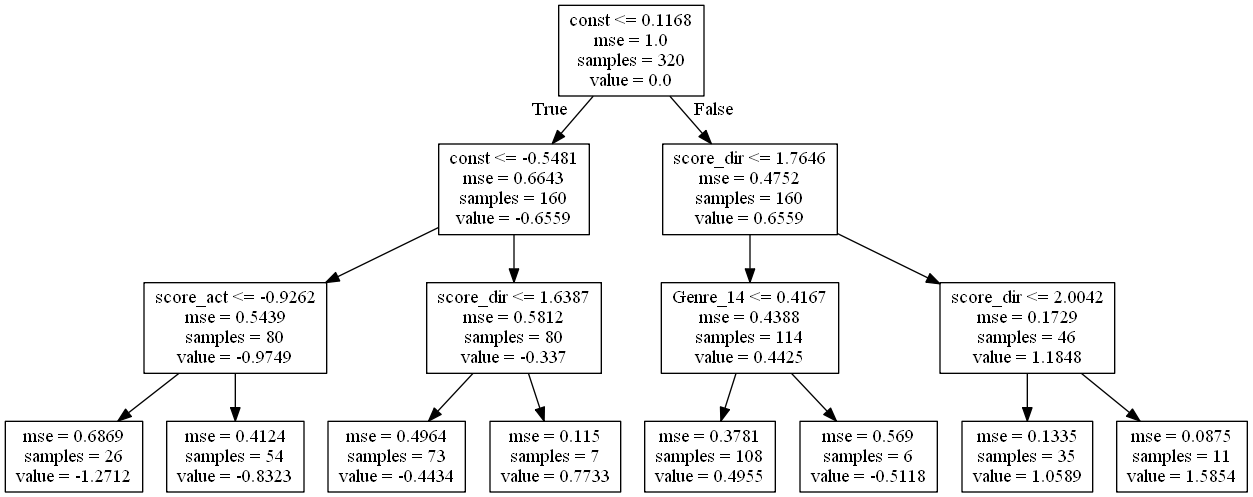

In [49]:
draw_decision_tree(tree1)

In [55]:
tree1.feature_importances_

array([ 0.79795467,  0.        ,  0.01752304,  0.15462943,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.02989286,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [53]:
dfx4.columns[1:]

Index([u'project_budget',      u'score_act',      u'score_dir',
            u'score_fra',        u'Genre_0',        u'Genre_1',
              u'Genre_2',        u'Genre_3',        u'Genre_4',
              u'Genre_5',        u'Genre_6',        u'Genre_7',
              u'Genre_8',        u'Genre_9',       u'Genre_10',
             u'Genre_11',       u'Genre_12',       u'Genre_13',
             u'Genre_14',       u'Genre_15',       u'Genre_16',
             u'Genre_17',       u'Genre_18',           u'sp_d',
                 u'su_d',           u'au_d',           u'wi_d',
                       0,                12,                15,
                      18],
      dtype='object')

In [57]:
X = dfx2.ix[:,1:]

In [58]:
import StringIO
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(classifier):
    dot_buf = StringIO.StringIO() 
    export_graphviz(classifier, out_file=dot_buf, feature_names=dfx2.columns[1:])
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

In [59]:
from sklearn.tree import DecisionTreeRegressor

tree1 = DecisionTreeRegressor(criterion='mse', max_depth=4, random_state=0).fit(X, y)

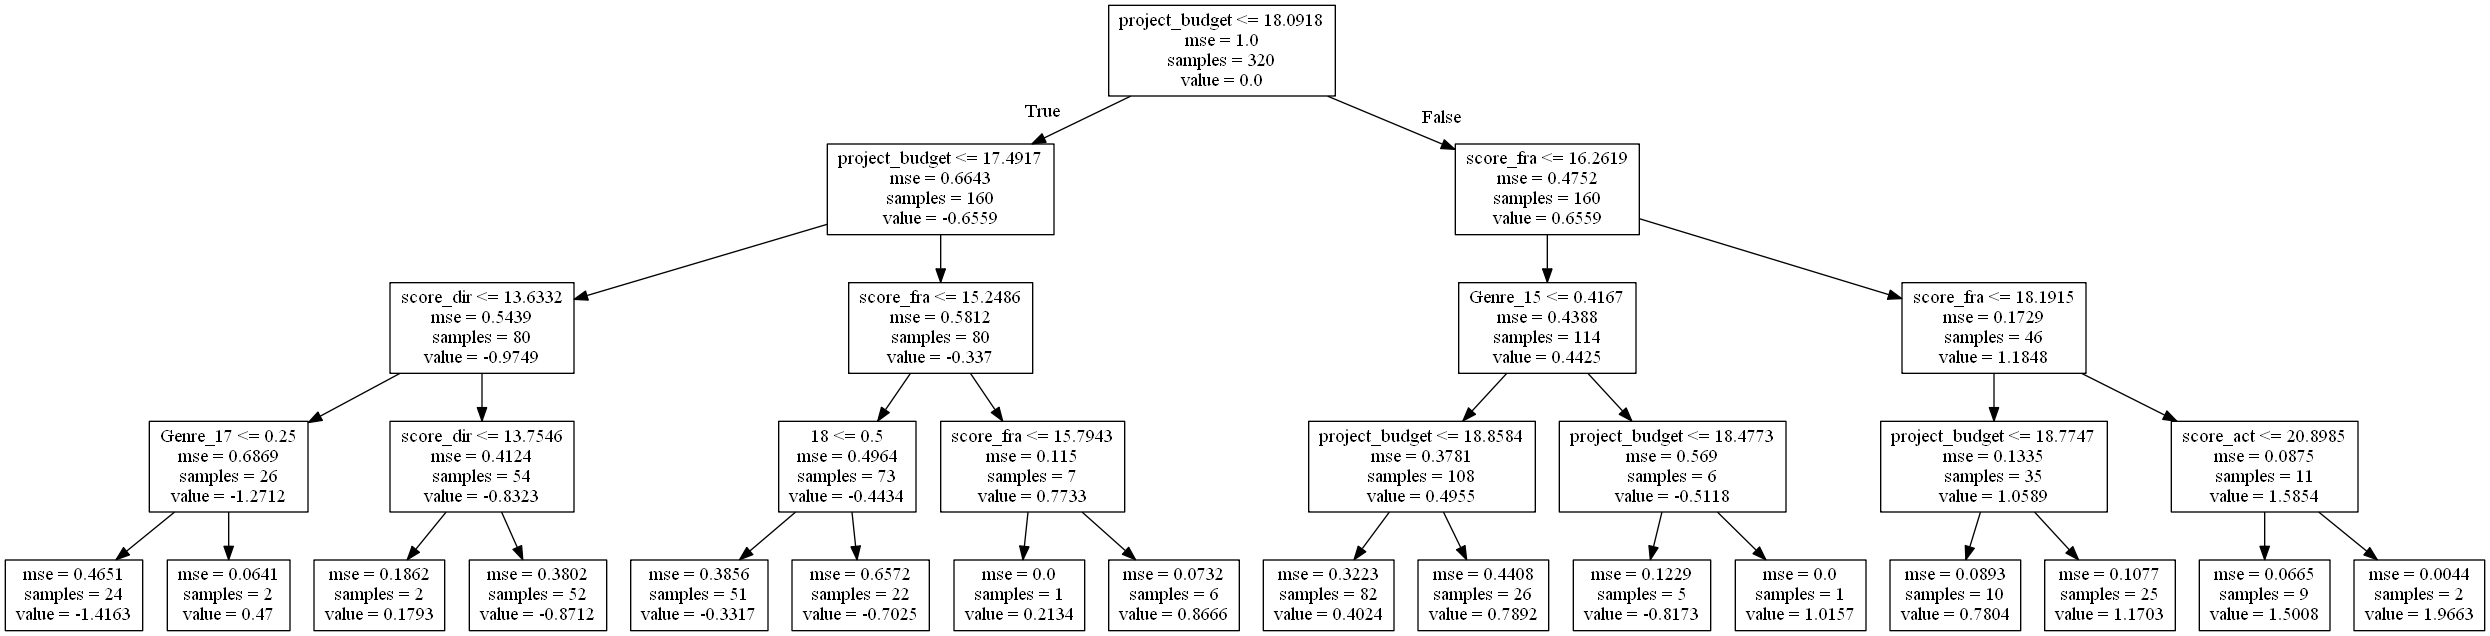

In [60]:
draw_decision_tree(tree1)

In [61]:
tree1.feature_importances_

array([ 0.76095766,  0.00167801,  0.02605807,  0.14291953,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.02729451,
        0.        ,  0.03108659,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01000563])

In [62]:
tree1.feature_importances_[19]

0.027294510247093711

In [76]:
dfx2.columns[1:][19]

u'Genre_15'

In [ ]:
dfx2.columns[20]